# Naive Bayes

The first thing you need to do is to download this file: <a href="mp02.zip">mp02.zip</a>.    Content is similar to MP01.

This file (`mp02_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Reading the Data</a>
1. <a href="#section2">Learning a Naive Bayes Model: Maximum Likelihood</a>
1. <a href="#section3">Learning a Naive Bayes Model: Stop Words</a>
1. <a href="#section4">Learning a Naive Bayes Model: Laplace Smoothing</a>
1. <a href="#section5">Decisions Using a Naive Bayes Model</a>
1. <a href="#section6">Optimizing Hyperparameters</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>

## Reading the data

The dataset in your template package consists of 10000 positive and 3000 negative movie reviews. It is a subset of the <a href="https://ai.stanford.edu/~amaas/data/sentiment/">Stanford Movie Review Dataset</a>, which was originally introduced by <a href="https://www.aclweb.org/anthology/P11-1015">this paper</a>. We have split this data set for you into 5000 development examples and 8000 training examples. The autograder also has a hidden set of test examples, generally similar to the development dataset. 

The data folder is structured like this:

```
  ├─ train
  │   ├─ neg
  │   │   └─ 2000 negative movie reviews (text)
  │   └─ pos
  │       └─ 6000 positive movie reviews (text)
  └─ dev
      ├─ neg
      │   └─ 1000 negative movie reviews (text)
      └─ pos
  │       └─ 4000 positive movie reviews (text)
```

In order to help you load the data, we provide you with a utility function called `reader.py`.  This has two new functions that didn't exist in mp01:

* loadTrain: load a training set
* loadDev: load a dev set

In [5]:
import reader, importlib
importlib.reload(reader)
help(reader.loadTrain)

Help on function loadTrain in module reader:

loadTrain(dirname, stemming, lower_case, use_tqdm=True)
    Loads a training dataset.
    
    Parameters:
    dirname (str): the directory containing the data
        - dirname/y should contain training examples from class y
    
    stemming (bool): if True, use NLTK's stemmer to remove suffixes
    lower_case (bool): if True, convert letters to lowercase
    use_tqdm (bool, default:True): if True, use tqdm to show status bar
    
    Output:
    train (dict of list of lists): 
        - train[y][i][k] = k'th token of i'th text of class y



This time the text files have not been lowercased for you in advance, so you probably want to lowercase them using the `lower_case` bool:

In [6]:
importlib.reload(reader)

train = reader.loadTrain('data/train', False, True)


100%|██████████| 6000/6000 [00:00<00:00, 19498.10it/s]


In [7]:
for y in train.keys():
    print("There were",len(train[y]),"texts loaded for class",y)

There were 2000 texts loaded for class neg
There were 6000 texts loaded for class pos


In [8]:
print("The first positive review is:",train['pos'][0])

The first positive review is: ['i', 'went', 'and', 'saw', 'this', 'movie', 'last', 'night', 'after', 'being', 'coaxed', 'to', 'by', 'a', 'few', 'friends', 'of', 'mine', 'i', 'll', 'admit', 'that', 'i', 'was', 'reluctant', 'to', 'see', 'it', 'because', 'from', 'what', 'i', 'knew', 'of', 'ashton', 'kutcher', 'he', 'was', 'only', 'able', 'to', 'do', 'comedy', 'i', 'was', 'wrong', 'kutcher', 'played', 'the', 'character', 'of', 'jake', 'fischer', 'very', 'well', 'and', 'kevin', 'costner', 'played', 'ben', 'randall', 'with', 'such', 'professionalism', 'the', 'sign', 'of', 'a', 'good', 'movie', 'is', 'that', 'it', 'can', 'toy', 'with', 'our', 'emotions', 'this', 'one', 'did', 'exactly', 'that', 'the', 'entire', 'theater', 'which', 'was', 'sold', 'out', 'was', 'overcome', 'by', 'laughter', 'during', 'the', 'first', 'half', 'of', 'the', 'movie', 'and', 'were', 'moved', 'to', 'tears', 'during', 'the', 'second', 'half', 'while', 'exiting', 'the', 'theater', 'i', 'not', 'only', 'saw', 'many', 'wom

<a id='section2'></a>

## Learning a Naive Bayes Model: Maximum Likelihood

In order to understand Naive Bayes, it might be useful to know the difference between word types and word tokens.

* **token:** The word tokens are the elements of the list.  The number of word tokens in the $n^{\text{th}}$ positive text is `len(train['pos'][n])`.
* **type:** The word types are the list of unique words that occurred in a review.  The number of word types in the $n^{\text{th}}$ positive text is `len(set(train['pos'][n]))`.



A Naive Bayes model consists of two types of probability distributions:

* The **prior** is the distribution over classes, $P(\text{Class})$.
* The **likelihood** is the probability of a word token given a particular class, $P(\text{Token}|\text{Class})$.

The prior can be estimated from the training data.  In your training data, $P(\text{Class}=\text{pos})=0.75$.  

Often, though, the testing data will have a different class distribution than the training data.  If you don't know the testing priors, then it's sometimes best to just assume a uniform distribution, i.e., $P(\text{Class}=\text{pos})=0.5$. 

The likelihood is the informative part of a Naive Bayes model: it tells you which words are used more often in negative versus positive movie reviews.

There are many ways in which you can estimate the likelihood.  The following formula is called the **maximum likelihood** estimate, because it maximizes the likelihood of the words in your training dataset:

$$P(\text{Token}=x|\text{Class}=y)=\frac{\text{\# tokens of word}~x~\text{in texts of class}~y}{\text{\# tokens of any word in texts of class}~y}$$



In this part of the MP, you will estimate what are called **frequency tables**.  The frequency of $x$ given $y$ is the number of times that word $x$ occurred in texts of class $y$.  The relevant method in `submitted.py` is the one called `create_frequency_table`:

In [10]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.create_frequency_table)

Help on function create_frequency_table in module submitted:

create_frequency_table(train)
    Parameters:
    train (dict of list of lists) 
        - train[y][i][k] = k'th token of i'th text of class y
    
    Output:
    frequency (dict of Counters) 
        - frequency[y][x] = number of tokens of word x in texts of class y



Edit `create_frequency_table` so that it does what its docstring says it should do.  

**Hint:** your code will be shorter if you use the python data structure called a <a href="https://docs.python.org/3/library/collections.html#collections.Counter">Counter</a>.

When your code works, you should get the following results:

In [33]:
importlib.reload(submitted)
frequency = submitted.create_frequency_table(train)

print("frequency['pos']['excellent']=",frequency['pos']['excellent'])
print("frequency['neg']['excellent']=",frequency['neg']['excellent'])
print("\n")

print("Total # tokens in pos texts is",sum(frequency['pos'].values()))
print("Total # tokens in neg texts is",sum(frequency['neg'].values()))
print("\n")

print("Total # types in pos texts is",len(frequency['pos'].keys()))
print("Total # types in neg texts is",len(frequency['neg'].keys()))

frequency['pos']['excellent']= 810
frequency['neg']['excellent']= 61


Total # tokens in pos texts is 1427513
Total # tokens in neg texts is 470194


Total # types in pos texts is 40829
Total # types in neg texts is 23901


<a id='section3'></a>

## Learning a Naive Bayes model: Stop words

here are a lot of common words, like "is, of, and", that seem to be obviously unrelated to whether a movie review is positive or negative.  Because of the way the database was collected, though, it's possible that some of those words are much more frequent in one part of the training data than another.  That's bad, because it means that a test review might be classified as "positive" just because it contains many examples of an innocuous word like "is".

A "stopword list" is a list of words that should not be considered when you classify a test text.  There are many candidate stopword lists available on the internet.  The stopword list that we've provided for you is based on this one: https://www.ranks.nl/stopwords

Here is our stopword list: 

In [13]:
importlib.reload(submitted)
print(sorted(submitted.stopwords))

["'d", "'ll", "'m", "'re", "'s", "'t", "'ve", 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'cannot', 'could', 'couldn', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', 'it', 'its', 'itself', 'let', 'll', 'me', 'more', 'most', 'mustn', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'shan', 'she', 'should', 'shouldn', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 

In order to avoid counting stopwords, two steps are necessary:

1. Pretend that their frequency in the training corpus is zero,
1. Ignore them if they occur in testing data.

In this part of the MP, you should set the frequencies of those stopwords to zero.  Use the `del` command (see <a href="https://docs.python.org/3/library/collections.html#collections.Counter">Counters</a>), so that these words don't get counted among either the word types or the word tokens.

In [14]:
importlib.reload(submitted)
help(submitted.remove_stopwords)

Help on function remove_stopwords in module submitted:

remove_stopwords(frequency)
    Parameters:
    frequency (dict of Counters) 
        - frequency[y][x] = number of tokens of word x in texts of class y
    
    Output:
    nonstop (dict of Counters) 
        - nonstop[y][x] = frequency of word x in texts of class y,
          but only if x is not a stopword.



In [52]:
importlib.reload(submitted)
nonstop = submitted.remove_stopwords(frequency)

print("frequency['pos']['excellent']=",frequency['pos']['excellent'])
print("nonstop['pos']['excellent']=",nonstop['pos']['excellent'])
print("\n")

print("frequency['pos']['you']=",frequency['pos']['you'])
print("nonstop['pos']['you']=",nonstop['pos']['you'])
print("\n")

print("Total pos frequency:",sum(frequency['pos'].values()))
print("Total pos non-stopwords",sum(nonstop['pos'].values()))
print("\n")

print("Total # types in pos texts is",len(frequency['pos'].keys()))
print("Total # non-stopwords in pos is",len(nonstop['pos'].keys()))

print("Length of the stopwords set is:",len(submitted.stopwords))

frequency['pos']['excellent']= 810
nonstop['pos']['excellent']= 810


frequency['pos']['you']= 7917
nonstop['pos']['you']= 0


Total pos frequency: 1427513
Total pos non-stopwords 769662


Total # types in pos texts is 40829
Total # non-stopwords in pos is 40687
Length of the stopwords set is: 150


<a id='section4'></a>

## Learning a Naive Bayes model: Laplace Smoothing

The maximum likelihood formula results in some words having zero probability, just because they were not contained in your training data.  A better formula is given by Laplace smoothing, according to which

$$P(\text{Token}=x|\text{Class}=y)=\frac{\left(\text{\# tokens of word}~x~\text{in texts of class}~y\right)+k}{\left(\text{\# tokens of any word in texts of class}~y\right)+k\times\left(\text{\# of word types}+1\right)}$$

...where $k$ is a hyperparameter that is usually chosen by trying several different values, and choosing the value that gives you the best accuracy on your development dataset.  

The `+1` in the denominator is used to account for words that were never seen in the training dataset for class $y$.  All such words are mapped to the type `OOV` (out of vocabulary), which has the likelihood

$$P(\text{Token}=\text{OOV}|\text{Class}=y)=\frac{k}{\left(\text{\# tokens of any word in texts of class}~y\right)+k\times\left(\text{\# of word types}+1\right)}$$

In this part of the MP, the method you'll create in `submitted.py` is called `laplace_smoothing`.

In [53]:
importlib.reload(submitted)
help(submitted.laplace_smoothing)

Help on function laplace_smoothing in module submitted:

laplace_smoothing(nonstop, smoothness)
    Parameters:
    nonstop (dict of Counters) 
        - nonstop[y][x] = frequency of x in y, if x not a stopword
    smoothness (float)
        - smoothness = Laplace smoothing hyperparameter
    
    Output:
    likelihood (dict of dicts) 
        - likelihood[y][x] = Laplace-smoothed likelihood of x given y
        - likelihood[y]['OOV'] = likelihood of an out-of-vocabulary word given y
    
    Be careful that your vocabulary only counts words that occurred at least once
    in the training data for class y.



In [54]:
importlib.reload(submitted)
likelihood = submitted.laplace_smoothing(frequency, 1)

print("likelihood['pos']['excellent']=",likelihood['pos']['excellent'])
print("likelihood['neg']['excellent']=",likelihood['neg']['excellent'])
print("\n")

print("likelihood['pos']['OOV']=",likelihood['pos']['OOV'])
print("likelihood['neg']['OOV']=",likelihood['neg']['OOV'])
print("\n")

print("likelihood['pos'] sums to",sum(likelihood['pos'].values()))
print("Likelihood['neg'] sums to",sum(likelihood['neg'].values()))



likelihood['pos']['excellent']= 0.0005523232650681755
likelihood['neg']['excellent']= 0.00012548168776917846


likelihood['pos']['OOV']= 6.810397843010795e-07
likelihood['neg']['OOV']= 2.023898189825459e-06


likelihood['pos'] sums to 0.9999999999996005
Likelihood['neg'] sums to 0.9999999999996396


<a id='section5'></a>

## Decisions using a Naive Bayes model

Suppose you are given a text, which is just a list of word tokens, $x=[x_1,\ldots,x_n]$.  You want to decide whether this text is a positive movie review or a negative review.  According to decision theory, the probability of error is minimized by the following rule:

$$\text{Estimated Class}=\left\{\begin{array}{ll}
\text{pos}~\text{if}~P(\text{Class}=\text{pos}|\text{Text}=x) > 
P(\text{Class}=\text{neg}|\text{Text}=x)\\
\text{neg}~\text{if}~P(\text{Class}=\text{pos}|\text{Text}=x) < 
P(\text{Class}=\text{neg}|\text{Text}=x)\\
\text{undecided}~\text{if}~P(\text{Class}=\text{pos}|\text{Text}=x) = 
P(\text{Class}=\text{neg}|\text{Text}=x)\end{array}\right.$$

The posterior probabilities $P(\text{Class}|\text{Text})$ can be estimated using the Naive Bayes model:

$$P(\text{Class}=y|\text{Text}=x)=\frac{P(\text{Class}=y)}{P(\text{Text}=x)}\prod_{i\not\in\text{stopwords},i=1}^nP(\text{Token}=x_i|\text{Class}=y)$$


#### Implementation Details

Notice some details:
1. The term $P(\text{Text}=x)$ doesn't depend on $y$.  If you're trying to figure out which is bigger, $P(\text{pos}|x)$ or $P(\text{neg}|x)$, then you don't need to calculate it.
1. Multiplying together $n$ probabilities will result in a number that your computer might round down to 0.  In order to prevent that, take the logarithm of both sides of the equation above.
1. If $x_i$ is a stopword, don't calculate its likelihood.  If it isn't a stopword, but it doesn't have an entry in `likelihood[y]`, then you should use `likelihood[y]["OOV"]`.

#### Implementation

For this part of the MP, finish the method called `submitted.naive_bayes`:

In [100]:
importlib.reload(submitted)
help(submitted.naive_bayes)

Help on function naive_bayes in module submitted:

naive_bayes(texts, likelihood, prior)
    Parameters:
    texts (list of lists) -
        - texts[i][k] = k'th token of i'th text
    likelihood (dict of dicts) 
        - likelihood[y][x] = Laplace-smoothed likelihood of x given y
    prior (float)
        - prior = the prior probability of the class called "pos"
    
    Output:
    hypotheses (list)
        - hypotheses[i] = class label for the i'th text



Use `reader.loadDev` to load the dev set, then try classifying it with, say, a prior of 0.5:

In [101]:
importlib.reload(reader)
texts, labels = reader.loadDev('data/dev', False, True, True)

for y in ['neg','pos']:
    print("There are",labels.count(y),'examples of class',y)

100%|██████████| 4000/4000 [00:00<00:00, 19407.97it/s]

There are 1000 examples of class neg
There are 4000 examples of class pos


In [105]:
importlib.reload(submitted)
hypotheses = submitted.naive_bayes(texts, likelihood, 0.5)

for y in ['neg','pos']:
    print("There are",hypotheses.count(y),'examples that were labeled with class',y)



There are 2016 examples that were labeled with class neg
There are 2984 examples that were labeled with class pos


In [106]:
print("The accuracy of the classifier on the dev set is:")

count_correct = 0
for (y,yhat) in zip(labels, hypotheses):
    if y==yhat:
        count_correct += 1
        
print(count_correct / len(labels))

The accuracy of the classifier on the dev set is:
0.7744


<a id='section6'></a>

## Optimizing Hyperparameters

The performance of the model is heavily influenced by two parameters that can't be measured from the training data:

1. The prior, $P(\text{Class}=\text{pos})$.  The training and testing data might have different priors, so estimating this from the training data is suboptimal.
1. The Laplace smoothing parameter, $k$.

Since these two parameters can't be (correctly) estimated from the training data, they are called **hyperparameters**.  Hyperparameters are usually determined based on your knowledge about the problem, or by running a lot of experiments to see which values give the best result on the development test data.

The function you'll write in this part of the MP is called `optimize_hyperparameters`.

In [79]:
importlib.reload(submitted)
help(submitted.optimize_hyperparameters)

Help on function optimize_hyperparameters in module submitted:

optimize_hyperparameters(texts, labels, nonstop, priors, smoothnesses)
    Parameters:
    texts (list of lists) - dev set texts
        - texts[i][k] = k'th token of i'th text
    labels (list) - dev set labels
        - labels[i] = class label of i'th text
    nonstop (dict of Counters) 
        - nonstop[y][x] = frequency of word x in class y, x not stopword
    priors (list)
        - a list of different possible values of the prior
    smoothnesses (list)
        - a list of different possible values of the smoothness
    
    Output:
    accuracies (numpy array, shape = len(priors) x len(smoothnesses))
        - accuracies[m,n] = dev set accuracy achieved using the
          m'th candidate prior and the n'th candidate smoothness



In [107]:
importlib.reload(submitted)
import numpy as np

priors = [0.65,0.75,0.85]
smoothnesses = [0.001,0.01,0.1]
accuracies = submitted.optimize_hyperparameters(texts,labels,nonstop,priors,smoothnesses)

(m,n) = np.unravel_index(np.argmax(accuracies), accuracies.shape)
print("The best accuracy achieved was",accuracies[m,n])
print("It was achieved for a prior of",priors[m])
print("  and a smoothness of",smoothnesses[n])

The best accuracy achieved was 0.8732
It was achieved for a prior of 0.85
  and a smoothness of 0.01


Let's use this function to test some different candidate values for the prior and the smoothness.  The values we test are a little arbitrary, but let's try the following:

Text(0.5, 1.0, 'Devset accuracy versus smoothness and prior')

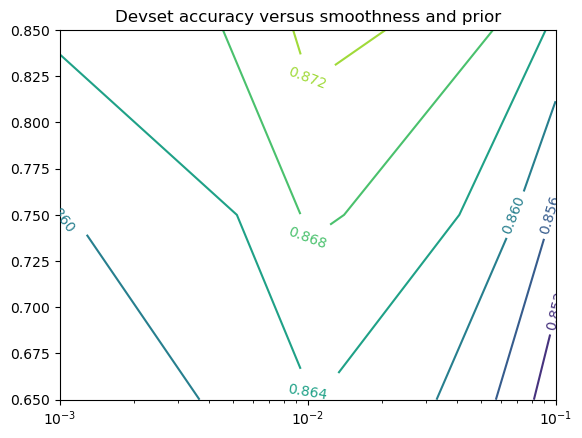

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
plt.xscale('log')
contours = ax.contour(smoothnesses, priors, accuracies)
ax.clabel(contours, inline=True, fontsize=10)
ax.set_title('Devset accuracy versus smoothness and prior')


<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [109]:
!python grade.py

.....
----------------------------------------------------------------------
Ran 5 tests in 7.522s

OK


If you got any 'E' marks, it means that your code generated some runtime errors, and you need to debug those.

If you got any 'F' marks, it means that your code ran without errors, but that it generated results that are different from the solutions in `solutions.json`.  Try debugging those differences.

If neither of those things happened, and your result was a series of dots, then your code works perfectly.  

If you're not sure, you can try running grade.py with the -j option.  This will produce a JSON results file, in which the best score you can get is 50.

Now you should try uploading `submitted.py` to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

Gradescope will run the same visible tests that you just ran on your own machine, plus some additional hidden tests.  It's possible that your code passes all the visible tests, but fails the hidden tests.  If that happens, then it probably means that you hard-coded a number into your function definition, instead of using the input parameter that you were supposed to use.  Debug by running your function with a variety of different input parameters, and see if you can get it to respond correctly in all cases.

Once your code works perfectly on Gradescope, with no errors, then you are done with the MP.  Congratulations!